```bash
python -m pip install git+https://github.com/stephwills/fragment_network_merges.git
python -m pip install joblib neo4j im-data-manager-job-utilities pebble
sudo apt-get install ffmpeg libsm6 libxext6  -y
export KUBECONFIG=$HOME/config-fragnet
export NEO4J_USER=matteo
export NEO4J_PASS=👾👾👾
export USE_NEO4J_INSTEAD_API=true
kubectl port-forward -n graph-b graph-0 7474:7474 &
kubectl port-forward -n graph-b graph-0 7687:7687 &
```

In [52]:
import os

os.environ['KUBECONFIG']=os.environ['HOME'] + '/config-fragnet'
os.environ['NEO4J_USER']='matteo'
os.environ['NEO4J_PASS']='👾👾👾'
os.environ['USE_NEO4J_INSTEAD_API']='true'

os.environ['FRAGALYSIS_DATA_DIR'] = os.path.join(os.getcwd(), 'fauxalysis')

assert os.environ['NEO4J_PASS'] != '👾👾👾', 'Fix placeholder...'

In [11]:
## Import hits

from rdkit import Chem

with Chem.SDMolSupplier('filtered_hits.sdf') as sds:
    hits = list(sds)
    
with Chem.SDMolSupplier('trimmed_x0771-x1604.sdf') as sds:
    hits.extend(list(sds))
    
hit_names = [hit.GetProp('_Name') for hit in hits]
hit_smileses = [Chem.MolToSmiles(hit) for hit in hits]
hitdex = dict(zip(hit_names, hits))

In [30]:
## Fauxalysis
from typing import List

def make_fauxalysis(hits: List[Chem.Mol], target_name: str, base_folder='.') -> None:
    if not os.path.exists(base_folder):
        os.mkdir(base_folder)
    os.environ['FRAGALYSIS_DATA_DIR'] = base_folder
    for hit in hits:
        hit_name: str = hit.GetProp('_Name')
        hit_path = os.path.join(base_folder, f'{target_name}', 'aligned',f'{target_name}-{hit_name}')
        os.makedirs(hit_path, exist_ok=True)
        Chem.MolToMolFile(hit, os.path.join(hit_path, f'{target_name}-{hit_name}.mol'))
           
target_name = 'EV-D68-protease'
make_fauxalysis(hits, target_name, os.path.join(os.getcwd(), 'fauxalysis'))

In [31]:
group1 = ('x1083L0AP1', 'x1305L0BP1', 'x1247L0AP1')
group2 = ('x0789L0AP1',
 'x0980L0BP1',
 'x1604L0AP1',
 'x1594L0AP1',
 'x0147L0AP1',
 'x0771L1AP1','x0771benzo', 'x1604base', 'x1604amino', 'x1604hydroxyl')
group3 = ('x1285L0BP1')

In [ ]:
## Search

from merge import query
from merge.find_merges import getFragmentNetworkSearcher
from merge.find_merges_generic import MergerFinder_generic  # solely for typehinting
from typing import Dict, List
import gzip, pickle

searcher: MergerFinder_generic = getFragmentNetworkSearcher()

valid_smileses, valid_names = searcher.filter_for_nodes(hit_smileses, hit_names)
smiles_pairs, name_pairs = searcher.get_combinations(valid_smileses, valid_names)
all_mergers: List[Dict] = []
for smiles_pair, name_pair in zip(smiles_pairs, name_pairs):
    grouping = [1 if n in group1 else (2 if n in group2 else 3 if n in group3 else 0) for n in name_pair]
    if 0 in grouping:
        continue
    if len(set(grouping)) == 1:
        continue
    print()
    mergers: Dict[str, List[str]] = searcher.get_expansions(smiles_pair, name_pair, target_name, 'output')
    all_mergers.append(dict(mergers=mergers, smiles_pair=smiles_pair, name_pair=name_pair))

with gzip.open('fragnet_pre.pkl.gz', 'wb') as fh:
    pickle.dump(all_mergers, fh)
    
print(f"N hits: {len(hits)} " + \
      f"N Merger sets: {len(all_mergers)} " + \
      f"N synthons: {sum([len(m['mergers']) for m in all_mergers])} " + \
      f"N mergers: {sum([len(mm) for m in all_mergers for mm in m['mergers'].values()])}")

7 fragments removed from list. 27 fragments remaining.

Expanding fragment A: x0771L1AP1 with synthons of fragment B: x1285L0BP1

Expanding fragment A: x0771L1AP1 with synthons of fragment B: x1083L0AP1

Expanding fragment A: x0980L0BP1 with synthons of fragment B: x1285L0BP1

Expanding fragment A: x0980L0BP1 with synthons of fragment B: x1083L0AP1

Expanding fragment A: x0147L0AP1 with synthons of fragment B: x1285L0BP1

Expanding fragment A: x0147L0AP1 with synthons of fragment B: x1083L0AP1

Expanding fragment A: x1285L0BP1 with synthons of fragment B: x0771L1AP1

Expanding fragment A: x1285L0BP1 with synthons of fragment B: x0980L0BP1

Expanding fragment A: x1285L0BP1 with synthons of fragment B: x0147L0AP1

Expanding fragment A: x1285L0BP1 with synthons of fragment B: x1594L0AP1

Expanding fragment A: x1285L0BP1 with synthons of fragment B: x1604L0AP1

Expanding fragment A: x1285L0BP1 with synthons of fragment B: x1083L0AP1

Expanding fragment A: x1285L0BP1 with synthons of fragme

In [37]:
print(f"N hits: {len(hits)} " + \
      f"N Merger sets: {len(all_mergers)} " + \
      f"N synthons: {sum([len(m['mergers']) for m in all_mergers])} " + \
      f"N mergers: {sum([len(mm) for m in all_mergers for mm in m['mergers'].values()])}")

N hits: 48 N Merger sets: 38 N synthons: 256 N mergers: 77155


In [40]:
## Parse synthons

import operator
import pandas as pd
from fragmenstein import Victor, Laboratory, Igor
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, BRICS
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import pandera.typing as pdt
from typing import List, Dict
import logging
import pyrosetta_help as ph
import pyrosetta

logger = ph.configure_logger()
logger.handlers[0].setLevel(logging.ERROR)

with open('reference.pdb') as fh:
    pdb_block = fh.read()

dfs = [ pd.DataFrame([{'smiles': synthon.replace('Xe', 'H'),
                       'original_name': f'{merge_info["name_pair"][1]}-synthon{i}',
                       'xenonic': synthon,
                       'parent': merge_info['name_pair'][1],
                       'hits': [hitdex[merge_info['name_pair'][1]]]} for i, synthon in enumerate(merge_info['mergers'].keys())])
       for merge_info in all_mergers
      ]

synthons = pd.concat(dfs, axis='index')

# fix duplicated
synthons.reset_index(drop=True, inplace=True)
synthons['inchi'] = synthons.smiles.apply(Chem.MolFromSmiles).apply(Chem.RemoveAllHs).apply(Chem.MolToInchiKey)    
synthons = synthons.drop_duplicates(['parent', 'inchi'])
synthons['name'] = synthons.parent +'S'+ (synthons.groupby(['parent']).cumcount()+1).astype(str)
Igor.init_pyrosetta()
placed_synthons = Laboratory(pdbblock=pdb_block, covalent_resi=None).place(synthons, n_cores=55)
placed_synthons.reset_index(drop=True, inplace=True)

def fix_name(row):
    # error... min_mol has it. not unmin.
    mol = Chem.Mol(row.unmin_binary)
    mol.SetProp('_Name', row['name'])
    return mol
    
name_check = placed_synthons['name']
assert (name_check != synthons['name']).sum() == 0, 'crap... tables are offset'
synthons['∆∆G'] = placed_synthons['∆∆G']
synthons['unmin_mol'] = placed_synthons.apply(fix_name, axis=1)
from rdkit.Chem import PandasTools
PandasTools.WriteSDF(df=synthons,
                     out='fragnet-synthons.sdf',
                     molColName='unmin_mol', 
                     idName='name',
                     properties=['parent', '∆∆G'])

PyRosetta-4 2023 [Rosetta PyRosetta4.Release.python310.ubuntu 2023.16+release.942c01d5066fd96860b7d268702b832fe906a739 2023-04-12T15:05:51] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [20]:
synthons['smiles'] = synthons.unmin_mol.apply(Chem.MolToSmiles)

In [21]:
synthons['inchi'] = synthons.smiles.apply(Chem.MolFromSmiles).apply(Chem.RemoveAllHs).apply(Chem.MolToInchiKey)    

In [232]:
print('DONE')

DONE


In [23]:
# fix names of synthons in combination and make it a long table
data = []
combodex: dict
for combodex in all_mergers:
    # 'mergers', 'smiles_pair', 'name_pair'
    first_name, second_name = combodex['name_pair']
    first: Chem.Mol = hitdex[first_name]
    for synthon_smiles in combodex['mergers']:
        clean_smiles = synthon_smiles.replace('Xe', 'H')
        inchi = Chem.MolToInchiKey( Chem.RemoveAllHs( Chem.MolFromSmiles(clean_smiles) ) )
        matched = synthons.loc[(synthons['parent'] == second_name) & (synthons.inchi == inchi)]
        if len(matched) == 0:
            print(second_name, clean_smiles, 'missing!')
            # Z2111637360
            second = hitdex[second_name]
            synthon_name = second_name+'X'
        elif matched.iloc[0]['∆∆G'] > -1.:
            # skip crap floater fragments
            continue
        else:
            second = matched.iloc[0].unmin_mol
            synthon_name = matched.iloc[0]['name']
        for i, smiles in enumerate(combodex['mergers'][synthon_smiles]):
            name = f'{first_name}-{synthon_name}-{i}'
            data.append(dict(name=name,
                             hits=[first, second], 
                             primary_name=first_name, 
                             secondary_parent=second_name, 
                             secondary_name=synthon_name,
                             smiles=smiles.replace('Xe', 'H')))
tabular_combinations = pd.DataFrame(data)

x1604L0AP1 CC1OC(=O)c2cc(Br)c([H])cc2O1 missing!
x1604L0AP1 CC1([H])OC(=O)c2cc(Br)ccc2O1 missing!
x1604L0AP1 CC1OC(=O)c2ccc([H])cc2O1 missing!
x1604L0AP1 CC1([H])OC(=O)c2ccccc2O1 missing!
x1604L0AP1 CC1OC(=O)c2cc([H])ccc2O1 missing!
x1604L0AP1 CC1OC(=O)c2cc([H])c(O)cc2O1 missing!
x1604L0AP1 CC1([H])OC(=O)c2ccc(O)cc2O1 missing!
x1604L0AP1 CC1([H])OC(=O)c2cc(Br)c(O)cc2O1 missing!
x1604L0AP1 CC1OC(=O)c2cc(Br)c([H])cc2O1 missing!
x1604L0AP1 CC1([H])OC(=O)c2cc(Br)ccc2O1 missing!
x1604L0AP1 CC1OC(=O)c2ccc([H])cc2O1 missing!
x1604L0AP1 CC1([H])OC(=O)c2ccccc2O1 missing!
x1604L0AP1 CC1OC(=O)c2cc([H])ccc2O1 missing!
x1604L0AP1 CC1OC(=O)c2cc([H])c(O)cc2O1 missing!
x1604L0AP1 CC1([H])OC(=O)c2ccc(O)cc2O1 missing!
x1604L0AP1 CC1([H])OC(=O)c2cc(Br)c(O)cc2O1 missing!


In [24]:
tabular_combinations.secondary_name.value_counts()

secondary_name
x0771benzoS1       4018
x1604baseS3        4018
x1604aminoS4       4018
x1604hydroxylS4    4018
x0980L0BP1S11       409
x1285L0BP1S3        164
x0771L1AP1S1         23
x1594L0AP1S1         23
Name: count, dtype: int64

In [26]:
# previous:
#logger = ph.configure_logger()
#Victor.enable_stdout(logging.INFO)
Victor.journal.handlers[0].setLevel(logging.ERROR)
Victor.journal.setLevel(logging.ERROR)

In [ ]:
## Place enumerations
    
lab = Laboratory(pdb_block, None)
Victor.monster_throw_on_discard = False  # currently there's a glitch as it throws if disconnected.
placed = lab.place(tabular_combinations, n_cores=55, expand_isomers=False)
with gzip.open('fragnet.placed.pkl.gz', 'wb') as fh:
    placed.to_pickle(fh)
placed.sort_values('∆∆G', ascending=True)

[2023-06-06 10:00:12,904] ERROR - [10:00:12] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[2023-06-06 10:00:12,910] ERROR - [10:00:12] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[2023-06-06 10:00:50,262] ERROR - [10:00:50] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[2023-06-06 10:00:50,267] ERROR - [10:00:50] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[2023-06-06 10:01:29,310] ERROR - [10:01:29] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[2023-06-06 10:01:29,314] ERROR - [10:01:29] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[2023-06-06 10:01:46,949] ERROR - [10:01:46] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[2023-06-06 10:01:46,956] ERROR - [10:01:46] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[2023-06-06 10:02:03,532] ERROR - [10:02:03] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[2023-06-06 10:02:03,537] ERROR - [10:02:03] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[2023-06-06 10:02:48,933] ERROR - [10:02:48] UFFTYPER: Unrecognized atom type: S_5+4 (3)
[2023-06-06 10:02:48,

In [33]:
placed.error.str.split(' ', expand=True)[0].value_counts()

0
                 16584
TimeoutError        91
ArgumentError       16
Name: count, dtype: int64

In [34]:
placed.loc[(placed.outcome == 'acceptable') & (placed['∆∆G'] <= -2)].sort_values('∆∆G', ascending=True)

,name,smiles,error,mode,∆∆G,∆G_bound,∆G_unbound,comRMSD,N_constrained_atoms,N_unconstrained_atoms,...,disregarded,unmin_binary,min_binary,hit_binaries,LE,unminimized_mol,minimized_mol,hit_mols,outcome,percent_hybrid
15351,x1083L0AP1-x1604hydroxylS4-1368,CCOC(=O)C(CCc1ccccc1)NC(C)C(=O)N1CCC(O)CC1,,expansion,-11.520050,-10.431007,1.089043,0.476786,16.0,10.0,...,[],b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,-0.443079,<rdkit.Chem.rdchem.Mol object at 0x7f1955d75620>,<rdkit.Chem.rdchem.Mol object at 0x7f1955c2eac0>,[<rdkit.Chem.rdchem.Mol object at 0x7f1955ab72...,acceptable,38.0
13270,x1083L0AP1-x1604aminoS4-1995,CC(COC(C)(C)C)NC(=O)N1CCC(Oc2ccccc2)CC1,,expansion,-10.681234,-10.428551,0.252683,0.345352,10.0,14.0,...,[],b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,-0.445051,<rdkit.Chem.rdchem.Mol object at 0x7f19560409a0>,<rdkit.Chem.rdchem.Mol object at 0x7f1955c55e40>,[<rdkit.Chem.rdchem.Mol object at 0x7f1955a059...,acceptable,0.0
16458,x1083L0AP1-x1604hydroxylS4-2475,COCC(C)(NC(=O)CCN1CCC(O)CC1)c1ccccc1,,expansion,-10.585904,-9.793769,0.792135,0.800048,17.0,8.0,...,[],b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,-0.423436,<rdkit.Chem.rdchem.Mol object at 0x7f1955d63150>,<rdkit.Chem.rdchem.Mol object at 0x7f1955c14630>,[<rdkit.Chem.rdchem.Mol object at 0x7f19559168...,acceptable,36.0
11588,x1083L0AP1-x1604aminoS4-313,COCCCCCNC(=O)N1CCC(Oc2ccccc2)CC1,,expansion,-10.562420,-9.997454,0.564966,0.294622,10.0,13.0,...,[],b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,-0.459236,<rdkit.Chem.rdchem.Mol object at 0x7f1956067a10>,<rdkit.Chem.rdchem.Mol object at 0x7f1955c74ef0>,[<rdkit.Chem.rdchem.Mol object at 0x7f1955b6ba...,acceptable,0.0
14463,x1083L0AP1-x1604hydroxylS4-480,CSCCC(NC(=O)Cc1ccccc1)C(=O)N1CCC(O)CC1,,expansion,-10.550834,-9.108120,1.442714,0.724988,16.0,8.0,...,[],b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,-0.439618,<rdkit.Chem.rdchem.Mol object at 0x7f195602ffb0>,<rdkit.Chem.rdchem.Mol object at 0x7f1955c3d490>,[<rdkit.Chem.rdchem.Mol object at 0x7f1955a705...,acceptable,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3026,x1285L0BP1-x1604aminoS4-319,OC1(c2ccccc2)CCN(CC2CC3CCC(C2)O3)CC1,,expansion,-2.006229,-0.569185,1.437044,0.566837,13.0,9.0,...,[],b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,-0.091192,<rdkit.Chem.rdchem.Mol object at 0x7f197fd94e50>,<rdkit.Chem.rdchem.Mol object at 0x7f1955d22070>,[<rdkit.Chem.rdchem.Mol object at 0x7f1955f0dd...,acceptable,0.0
4058,x1285L0BP1-x1604hydroxylS4-41,C=CC(N)C1(O)CCN(Cc2ccccc2)CC1,,expansion,-2.004363,-1.527857,0.476507,0.614446,13.0,5.0,...,[],b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,-0.111354,<rdkit.Chem.rdchem.Mol object at 0x7f19560f4c20>,<rdkit.Chem.rdchem.Mol object at 0x7f1955d0de40>,[<rdkit.Chem.rdchem.Mol object at 0x7f1955f4d9...,acceptable,0.0
4209,x1285L0BP1-x1604hydroxylS4-192,O=C(NCC1(O)CCN(Cc2ccccc2)CC1)C(F)F,,expansion,-2.004144,-0.809889,1.194255,0.626722,13.0,8.0,...,[],b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,-0.095435,<rdkit.Chem.rdchem.Mol object at 0x7f19560f7a10>,<rdkit.Chem.rdchem.Mol object at 0x7f1955d08c70>,[<rdkit.Chem.rdchem.Mol object at 0x7f1955f535...,acceptable,0.0

In [44]:
from rdkit.Chem import PandasTools

valids = placed.loc[(placed.outcome == 'acceptable') & (placed.minimized_mol.apply(lambda m: isinstance(m, Chem.Mol)))]\
                  .sort_values('∆∆G').drop_duplicates('name')

In [54]:
from rdkit.Chem import AllChem
from merge import query
from merge.find_merges import getFragmentNetworkSearcher
from merge.find_merges_generic import MergerFinder_generic  # solely for typehinting
from typing import Dict, List
import gzip, pickle

searcher: MergerFinder_generic = getFragmentNetworkSearcher()

# get names!

def get_names(smiles: str) -> str:
    #placed_synthons['catalogue_name'] = placed_synthons.clean_smiles.apply(get_name)
    
    try:
        with searcher.getSearchSession() as session:
            node = session.find_molecule_node(smiles)
            return node['cmpd_ids']
    except Exception as error:
        print(error)
        return ''

#get_names(valids.iloc[0].smiles)
valids['catalogue_names'] = valids.smiles.apply(get_names)

In [57]:
i = 0

def get_first_name(names: List[str]) -> str:
    if len(names) == 0:
        global i
        i += 1
        return f'UNKNOWN{i}'
    for name in names:
        if 'ENAMINE:' in name:
            return name
    return names[0]
    

valids['catalogue_name'] = valids.catalogue_names.apply(get_first_name)

In [60]:
from pathlib import Path

valids['path'] = valids.name.apply(lambda n: Path('output') / n / f'{n}.holo_minimised.pdb')
valids.path.apply(Path.exists).value_counts()

path
True    8825
Name: count, dtype: int64

In [61]:
valids.to_pickle('fragnet_acceptables.pkl.gz')
PandasTools.WriteSDF(df=valids,
                    out=f'fragnet_placements.sdf',
                    molColName='minimized_mol',
                    idName='name',
                    properties=['regarded', 'smiles', '∆∆G', '∆G_bound', '∆G_unbound',
       'comRMSD', 'N_constrained_atoms', 'N_unconstrained_atoms', 'runtime',
       'LE',  'outcome', 'catalogue_name',
       'percent_hybrid']
                    )

valids[['name', 'regarded', 'smiles', '∆∆G', '∆G_bound', '∆G_unbound',
       'comRMSD', 'N_constrained_atoms', 'N_unconstrained_atoms', 'runtime',
       'LE',  'outcome', 'catalogue_name',
       'percent_hybrid']].to_csv(f'fragnet_placements.csv')

In [62]:
len(valids)

8825

In [63]:
"""
https://github.com/matteoferla/PLIP-PyRosetta-hotspots-test/blob/main/plipspots_docking/plipspots/serial.py

This is a class I use to _apply_ PLIP to a pd.Series of molecules.
It is not built for the project, but works.
Note I have not dumped the methods that are not needed for the project.
"""

import os
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

from functools import singledispatchmethod
from typing import Tuple, Dict, List, Union
from collections import Counter, defaultdict
from plip.structure.preparation import PDBComplex, PLInteraction
from openbabel.pybel import Atom, Residue
from openbabel.pybel import ob
from fragmenstein.victor import MinimalPDBParser
import warnings


class SerialPLIPper:
    """
    Calling the instance will return a ``Dict[Tuple[str, str, int], int]``,
    where the key is interaction type, residue 3-letter name, residue index
    and the value is the count of interactions.
    Basically, applying Plip to a pd.Series of Chem.Mol.

    Unplacking it is kind of wierd, the best way I reckon is a brutal for-loop:

    .. code-block:: python

        import pandas as pd
        import pandera.typing as pdt

        intxndexes: pdt.Series[Dict[Tuple[str, str, int], int]] = hits.ROMol.apply(SerialPLIPper(pdb_filename))
        # columns will still be a tuple...:
        intxn_df = pd.DataFrame(intxndexes.to_list()).fillna(0).astype(int)
        hits['N_interactions'] = intxn_df.sum(axis='columns')
        for c in sorted(intxn_df.columns, key=lambda kv: kv[2]):
            # columns will be a colon-separated string:
            hits[':'.join(map(str, c))] = intxn_df[c]
    """

    def __init__(self, pdb_block: str, resn='LIG', chain='B'):
        assert 'ATOM' in pdb_block, f'No ATOM entry in block provided: {pdb_block}'
        self.pdb_block = pdb_block
        self.resn = resn
        self.chain = chain

    @classmethod
    def from_filename(cls, pdb_filename: str, *args, **kwargs):
        """
        The main constructor is from PDB block, this is from PDB file
        """
        with open(pdb_filename, 'r') as f:
            pdb_block = f.read()
        return cls(pdb_block, *args, **kwargs)

    def __call__(self, mol) -> Dict[Tuple[str, str, int], int]:
        if mol is None or not isinstance(mol, Chem.Mol) or mol.GetNumAtoms() == 0:
            return {}
        holo: str = self.plonk(mol)
        interaction_set: PLInteraction = self.get_interaction_set(holo)
        return self.get_interaction_counts(interaction_set)

    def assign_pdb(self, mol: Chem.Mol):
        """
        Fix the PDB info for the molecule, in place
        """
        counts = defaultdict(int)
        atom: Chem.Atom
        for atom in mol.GetAtoms():
            element: str = atom.GetSymbol()
            counts[element] += 1
            info = Chem.AtomPDBResidueInfo(atomName=f'{element: >2}{counts[element]: <2}',
                                           residueName=self.resn,
                                           residueNumber=1, chainId=self.chain)
            atom.SetPDBResidueInfo(info)

    def plonk(self, mol):
        """
        Temporarily here. Do not copy.
        There likely is a way to do this in OBabel
        This is using Fragmenstein ``MinimalPDBParser``.

        :param mol:
        :return:
        """
        pdbdata = MinimalPDBParser(self.pdb_block, remove_other_hetatms=True, ligname=self.resn)
        self.assign_pdb(mol)
        moldata = MinimalPDBParser(Chem.MolToPDBBlock(mol))
        pdbdata.append(moldata)
        return str(pdbdata)

    @singledispatchmethod
    def get_interaction_set(self) -> PLInteraction:
        """
        Overloaded method: block or mol return the iternaction set
        :return:
        """
        raise NotImplementedError

    @get_interaction_set.register
    def _(self, block: str) -> PLInteraction:
        holo = PDBComplex()
        holo.load_pdb(block, as_string=True)
        holo.analyze()
        return holo.interaction_sets[':'.join([self.resn, self.chain, str(1)])]

    @get_interaction_set.register
    def _(self, mol: Chem.Mol) -> PLInteraction:
        if mol.GetNumAtoms() == 0:
            raise ValueError('Molecule has no atoms')
        holo = PDBComplex()
        holo.load_pdb(self.plonk(mol), as_string=True)
        holo.analyze()
        return holo.interaction_sets[':'.join([self.resn, self.chain, str(1)])]

    def get_atomname(self, atom: Union[Atom, ob.OBAtom]) -> str:
        """
        Given an atom, return its name.
        """
        if isinstance(atom, Atom):
            res: ob.OBResidue = atom.residue.OBResidue
            obatom = atom.OBAtom
        elif isinstance(atom, ob.OBAtom):
            obatom: ob.OBAtom = atom
            res: ob.OBResidue = obatom.GetResidue()
        else:
            raise TypeError
        return res.GetAtomID(obatom)

    def get_atom_by_atomname(self, residue: Union[ob.OBResidue, Residue], atomname: str) -> ob.OBAtom:
        """
        Get an atom by its name in a residue.
        """
        if isinstance(residue, Residue):
            residue = residue.OBResidue
        obatom: ob.OBAtom
        for obatom in ob.OBResidueAtomIter(residue):
            if residue.GetAtomID(obatom).strip() == atomname:
                return obatom
        else:
            raise ValueError(f'No atom with name {atomname} in residue {residue.GetName()}')

    def get_interaction_counts(self, interaction_set: PLInteraction) -> Dict[Tuple[str, str, int], int]:
        """
        Count the number of interactions of each type for each residue
        """
        intxns: List = interaction_set.all_itypes
        intxn_dex = defaultdict(int)
        for intxn in intxns:
            key = (intxn.__class__.__name__, intxn.restype, intxn.resnr)
            intxn_dex[key] += 1
        return dict(sorted(intxn_dex.items(), key=lambda kv: kv[0][2]))

In [64]:
chain_check = {l[21:26].strip() for l in valids.iloc[0].path.read_text().split('\n') if ' LIG ' in l} - {'LIG'}
print(chain_check)
chain = next(iter(chain_check)).split()[0]

import operator

plipper = SerialPLIPper('ATOM', resn='LIG', chain=chain)
def get_intxns(path: Path) -> dict:
    interaction_set: PLInteraction = plipper.get_interaction_set(path.read_text())
    return plipper.get_interaction_counts(interaction_set)

intxns = valids.path.apply(get_intxns)
key_order = sorted(set(intxns.apply(lambda d: list(d.keys())).sum()), key=operator.itemgetter(2))
for key in key_order:
    valids[key] = intxns.apply(lambda d: d.get(key, 0))
valids['N_interactions'] = valids[key_order].sum(axis=1)

valids.to_pickle('acceptables.pkl.gz')
valids[['name', 'regarded', 'smiles', '∆∆G', '∆G_bound', '∆G_unbound',
       'comRMSD', 'N_constrained_atoms', 'N_unconstrained_atoms', 'runtime',
       'LE',  'outcome',
       'percent_hybrid', 'N_interactions'] + key_order].to_csv('fragnet_interactions.csv')
print('done')

{'B   1'}
done


In [68]:
valids['N_interactions'].value_counts().sort_index()

N_interactions
0       55
1      330
2     1054
3     2190
4     2365
5     1770
6      803
7      201
8       45
9        9
10       2
11       1
Name: count, dtype: int64

In [87]:
import re

def unbleach2(name: str, raise_error=True):
    regex = re.match(r'(x\d+)L(\w+)P(\d+)', name)
    if regex:
        return f'{regex.group(1)}@{regex.group(2)}-{regex.group(3)}'
    # special
    regex = re.match(r'(x\d+\w+)S', name)
    if regex:
        return f'{regex.group(1)}'
    regex = re.match(r'(x\d+\w+)', name)
    if regex:
        return f'{regex.group(1)}'
    if raise_error:
        raise Exception(name)
    return name
    
valids['hit_names'] = valids.regarded.apply(lambda l: [unbleach2(n) for n in l])

In [101]:
from michelanglo_api import MikeAPI
from rdkit import Chem
from typing import List
import pandas as pd
import json

# declare variables
hit_names = [unbleach2(n, False) for n in hitdex]
!mkdir -p upload
!cp filtered_hits.sdf upload/EV-D68_hits2.sdf
hit_filename = 'EV-D68_hits2.sdf'

headers = ['name', 'hits', 'code', 'RMSD', '∆∆G', 'LE', 'N unconstrained atoms', 'N constrained atoms', 'N interactions']
metadata: pd.DataFrame = valids.rename(columns=dict(hit_names='hits', comRMSD='RMSD',
                                                    dist='distance',
                                                    catalogue_name='code',
                                                    N_constrained_atoms='N constrained atoms',
                                                    N_unconstrained_atoms='N unconstrained atoms',
                                                    N_interactions='N interactions'))[headers]
metadata_filename: str = 'EV-D68_metadata2.json'

for k in ('∆∆G', 'LE', 'RMSD'):
    metadata[k] = metadata[k].fillna(999).astype(float).round(1)
for k in ('N unconstrained atoms',):
    metadata[k] = metadata[k].fillna(-1).astype(int)
metadata = metadata.copy()


base_url = 'https://www.stats.ox.ac.uk/~ferla/mols/'  # base url path
uuid = 'e934e6d1-61e4-4fe8-b57f-166bd5e37c31' # uuid of the page target

placement_filename = 'EV-D68_fragnet.sdf'
with Chem.SDWriter('upload/'+ placement_filename) as sdw:
    placement_names = []
    for i, row in valids.iterrows():
        row.minimized_mol.SetProp('_Name', row['name'])
        if row.minimized_mol.GetNumAtoms() == 0:
            continue
        sdw.write(row.minimized_mol)
        placement_names.append(row['name'])
        
with open('upload/'+ metadata_filename, 'w') as fh:
    json.dump(dict(
                   headers=headers,
                   data=metadata.values.tolist(),
                   modelnamedex={'fragnet': placement_names,
                                },
                   hitnames=hit_names,
            ), fh)
    
# make a page

mike = MikeAPI()
page = mike.get_page(uuid)

page.loadfun = page.get_fragment_js(hit_sdf_url=base_url+hit_filename,
                               model_sdf_urldex={'fragnet' : base_url+placement_filename,
                                                },
                               metadata_url=base_url+metadata_filename,
                               model_colordex={'fragnet': 'salmon'},
                               hit_color='grey',
                               template_color='gainsboro',
                               name_col_idx = headers.index('name'),
                               hit_col_idx = headers.index('hits'),
                               target_col_idx = -1, # headers.index('target')
                               sort_col = headers.index('N interactions'),
                               sort_dir = 'desc',
                               fun_name ='loadTable')

# create a way to load the protein
# laziest: 
#page.loadfun += 'setTimeout(loadTable, 1000)'
# better:
page.loadfun += """
window.loadprotein = (prot) => {prot.removeAllRepresentations(); 
                                prot.addRepresentation('cartoon');
                                prot.addRepresentation('line');
                                prot.autoView(); 
                                prot.setName('template');
                                loadTable(); 
                                }
"""
page.loadfun = page.loadfun.replace('"model_colordex": {"combination": "teal", "placement": "teal"}',
                                    '"model_colordex": {"combination": "salmon", "placement": "turquoise"}'
                                   )
page.proteins[0]['loadFx'] = 'loadprotein'
page.title = 'EV-D68 3C protease followups — Fragment Network'
page.description = f'## Predicted followups\n Followups in salmon.\n\n. Protein is constant for the sake of memory, but induced fit may have repacked the protein in specific case hence the odd case of calculated nice score and visual clashes.\n\nRMSD cutoff loosened to 2Å'
page.columns_text = 6
page.commit()
print('Done')

Done


In [274]:
tabular_combinations.loc[tabular_combinations['name'].str.contains('x1285L0BP1S6') & (tabular_combinations.primary_name == 'x0771benzo')]

,name,hits,primary_name,secondary_parent,secondary_name,smiles


In [275]:
tabular_combinations

,name,hits,primary_name,secondary_parent,secondary_name,smiles
0,x1285L0BP1-x0771L1AP1S1-0,[<rdkit.Chem.rdchem.Mol object at 0x7fe01bd0ad...,x1285L0BP1,x0771L1AP1,x0771L1AP1S1,CN1CCC(O)(CNC(=O)Nc2ccc3c(c2)CCN3)CC1
1,x1285L0BP1-x0771L1AP1S1-1,[<rdkit.Chem.rdchem.Mol object at 0x7fe01bd0ad...,x1285L0BP1,x0771L1AP1,x0771L1AP1S1,c1cc2c(cc1CN1CCCCC1)CCN2
2,x1285L0BP1-x0771L1AP1S1-2,[<rdkit.Chem.rdchem.Mol object at 0x7fe01bd0ad...,x1285L0BP1,x0771L1AP1,x0771L1AP1S1,CN1CCCC(c2ccc3c(c2)CCN3)C1
3,x1285L0BP1-x0771L1AP1S1-3,[<rdkit.Chem.rdchem.Mol object at 0x7fe01bd0ad...,x1285L0BP1,x0771L1AP1,x0771L1AP1S1,CN1CCC(Oc2ccc3c(c2)CCN3)CC1
4,x1285L0BP1-x0771L1AP1S1-4,[<rdkit.Chem.rdchem.Mol object at 0x7fe01bd0ad...,x1285L0BP1,x0771L1AP1,x0771L1AP1S1,c1cc2c(cc1OC1CCNCC1)CCN2
...,...,...,...,...,...,...
16686,x1083L0AP1-x1604hydroxylS4-2703,[<rdkit.Chem.rdchem.Mol object at 0x7fe01bd0b8...,x1083L0AP1,x1604hydroxyl,x1604hydroxylS4,CCN(CC(C)O)C(=O)C(c1ccccc1)N1CCC(O)CC1
16687,x1083L0AP1-x1604hydroxylS4-2704,[<rdkit.Chem.rdchem.Mol object at 0x7fe01bd0b8...,x1083L0AP1,x1604hydroxyl,x1604hydroxylS4,CC(C)N(Cc1ccccc1)CC1(O)CCNCC1
16688,x1083L0AP1-x1604hydroxylS4-2705,[<rdkit.Chem.rdchem.Mol object at 0x7fe01bd0b8...,x1083L0AP1,x1604hydroxyl,x1604hydroxylS4,O=S(=O)(CC1CNCCO1)N1CCC(Oc2ccccc2)CC1
16689,x1083L0AP1-x1604hydroxylS4-2706,[<rdkit.Chem.rdchem.Mol object at 0x7fe01bd0b8...,x1083L0AP1,x1604hydroxyl,x1604hydroxylS4,O=S(=O)(CC1CCNCC1)N1CCCC(c2ccccc2)C1


In [145]:
## Junkyard

In [146]:
# there is an issue. Benzene is winning...
import functools, operator

used = list(set(functools.reduce(operator.add, valids.regarded.to_list(), [])))
used

['x1285L0BP1S3',
 'x1604baseS3',
 'x0771L1AP1S1',
 'x0771benzoS1',
 'x1604aminoS4',
 'x0980L0BP1S11',
 'x1285L0BP1',
 'x1594L0AP1S1',
 'x1083L0AP1',
 'x1604hydroxylS4']

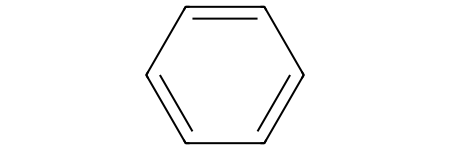

In [147]:
Chem.MolFromSmiles(synthons.set_index('name').loc['x1604hydroxylS4'].smiles)

In [148]:
good_names = ['x1285L0BP1S3',
 'x0771L1AP1S1',
 'x0980L0BP1S11',
 'x1285L0BP1',
 'x1594L0AP1S1',
 'x1083L0AP1']

def is_nonbenzene(l):
    for n in l:
        if l not in good_names:
            return False
    return True

valids['_keep'] = valids.regarded.apply(is_nonbenzene)
valids._keep.value_counts()

_keep
False    8825
Name: count, dtype: int64

In [285]:

Chem.MolToSmiles(AllChem.RemoveAllHs(synthons.set_index('name').loc['x1285L0BP1S6'].unmin_mol))

'C1CCNCC1'

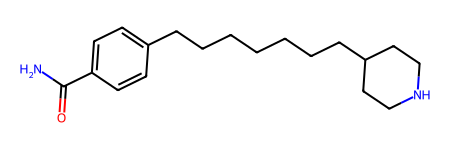

In [289]:
Chem.MolFromSmiles()

In [293]:
faux = pd.DataFrame([dict(name='test',
                          smiles='NC(=O)c1ccc(CCCCCCCCCC2CCNCC2)cc1',
                          hits=[hitdex['x0771benzo'],
                                synthons.set_index('name').loc['x1285L0BP1S6'].unmin_mol])])

In [294]:
lab.place(faux, n_cores=55, expand_isomers=False)

[2023-06-06 09:35:09,775] CRITICAL - *** DistanceError x0771benzo+x1285L0BP1S6 for test
[2023-06-06 09:35:10,039] CRITICAL - No results were found. Returning an empty dataframe.


,error,name
0,DistanceError x0771benzo+x1285L0BP1S6,test


In [303]:
from fragmenstein import Monster

Monster.journal.setLevel(logging.DEBUG)
Monster.journal.handlers[0].setLevel(logging.DEBUG)

h = [hitdex['x0771benzo'],
         synthons.set_index('name').loc['x1285L0BP1S6'].unmin_mol]

#Monster(h).place_smiles('NC(=O)c1ccc(CCCCCCCCCC2CCNCC2)cc1').positioned_mol

In [ ]:
v = Victor(h, pdb_block=pdb_block)
v.place('NC(=O)c1ccc(CCCCCCCCCC2CCNCC2)cc1').minimized_mol

In [309]:
v.monster._compute_overlaps()

{('x0771benzo', 'x1285L0BP1S6'): {}, ('x1285L0BP1S6', 'x0771benzo'): {}}